## Processing Sensor Data from Catalina Jemez CZO BGZOB Pit 1
- Marc Berghouse 9/19/2020: original format
- Zach Perzan 9/23/2020: improved format and working PRISM concat
- Zach Perzan 11/10/2020: created remove_spikes function

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS6
- Decagon5TE
- Vertical redox prodes from Paleo Terra

Issues:
- 2 sensors at 60cm. Not sure if the mask applied to O2 data should be lower.
- I'm not sure which water potential values are unrealistic


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

def remove_spikes(df, column, window=7, threshold=1):
    """Given a dataframe and column, remove values that are different 
    from the rolling median. For example, with window=5 and threshold=1000 ppm,
    values that are more than 1000 ppm off from the 5-value rolling median will
    be set to NaN.
    
    params: 
        df [dataframe]: dataframe in which the 
        column [str]: name of the column to modify within df
        window [int]: number of records over which to take the median
        threshold [float]: threshold difference above which values are 
            removed (set to NaN)
            
    returns:
        nothing (modifies data in place)
    """
    
    data = df[column].copy()
    
    rollmed = data.rolling(window).median()
    diff = (data - rollmed).abs()
    mask = diff > threshold
    data[mask] = np.nan
    
    df[column] = data

In [2]:
infiles = ["../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_co2o2_2014.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_co2o2_2015.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_co2o2_2016.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_soilMTP_2014.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_soilMTP_2015.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_soilMTP_2016.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_soilMTP_2017.csv"]  
        
infiles_redox = ["../../raw_data/Catalina-Jemez/BGZOB_Pit1/BigelowRedox_2015.csv", 
            "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BigelowRedox_2016.csv", 
             "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BigelowRedox_2017.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
for infile in tqdm(infiles_redox):
    df2 = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1], usecols = ['DateTime','Pit1_ORP_5','Pit1_ORP_10','Pit1_ORP_30','Pit1_ORP_60']) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df2)


prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_BGZOB_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=['ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 
         'ApogeeTemp_60(2)cm.deg.C', 'O2_10cm.percent.0-100','O2_30cm.percent.0-100',
         'O2_60cm.percent.0-100', 'O2_60(2)cm.percent.0-100', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 
         'CO2_60cm.ppm', 'CO2_60(2)cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa',
         'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoisture_10cm.m3m3', 
         'SoilMoisture_30cm.m3m3', 'SoilMoisture_60cm.m3m3', 'SoilMoisture_60(2)cm.m3m3', 
         'BulkEC_10cm.dS/m', 'BulkEC_30cm.dS/m', 'BulkEC_60cm.dS/m', 'BulkEC_60(2)cm.dS/m', 
         'Decagon5TETemp_10cm.deg.C','Decagon5TETemp_30cm.deg.C', 'Decagon5TETemp_60cm.deg.C', 
         'Decagon5TETemp_60(2)cm.deg.C','ReductionPotential_5cm.mV', 'ReductionPotential_10cm.mV',
         'ReductionPotential_30cm.mV', 'ReductionPotential_60cm.mV' ]

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2013-03-08', '2014-11-21'), errors='ignore')
#ppt = ppt.drop(pd.date_range('2018-10-02', '2019-06-24'), errors='ignore')
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

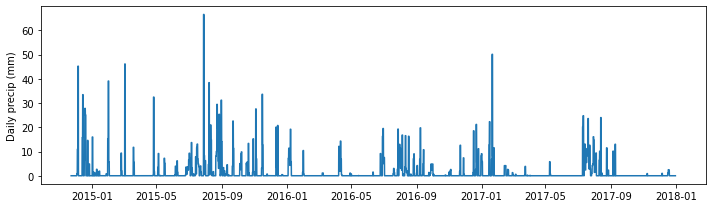

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

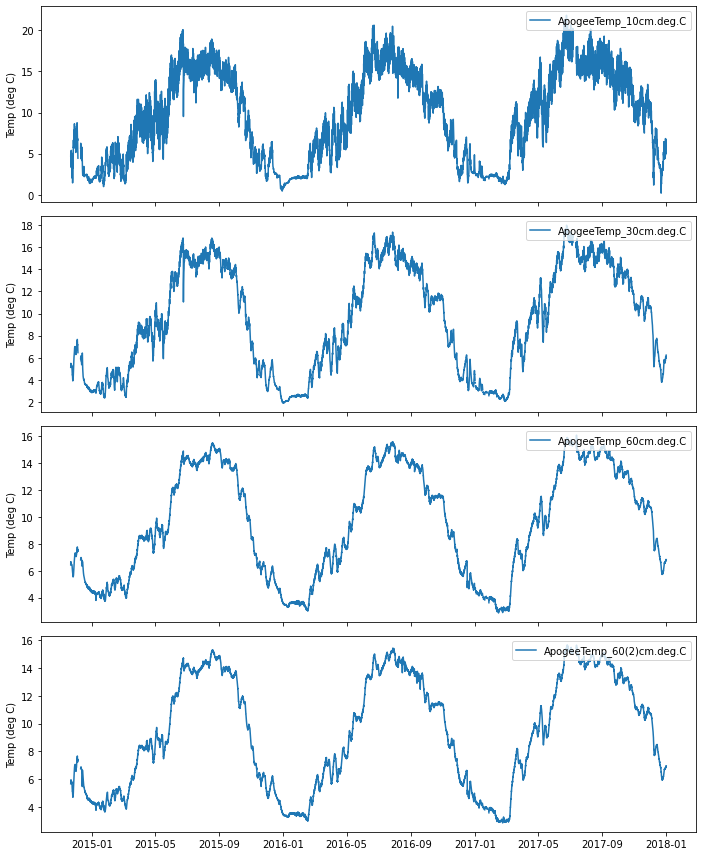

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

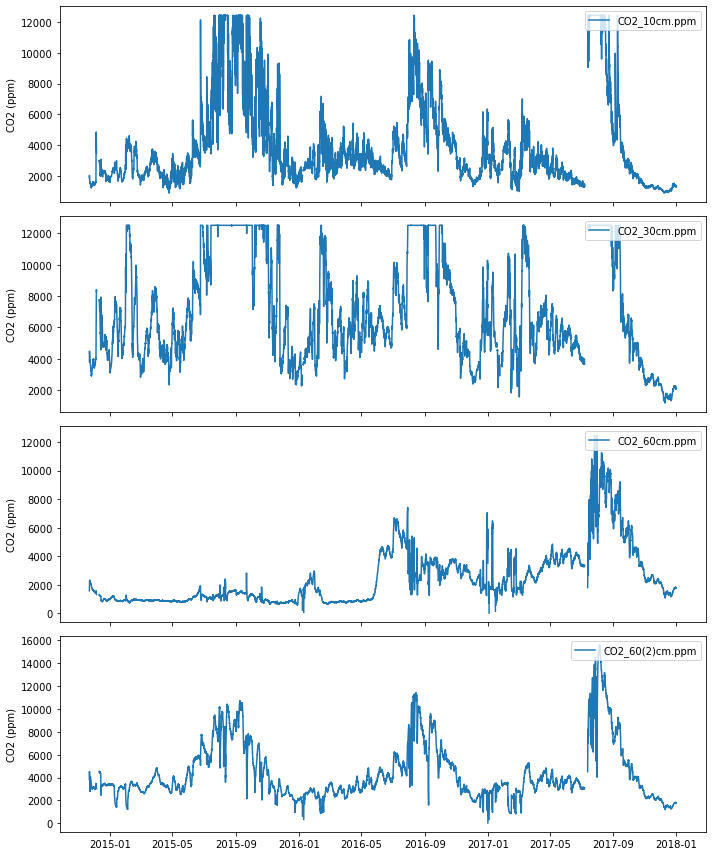

In [6]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

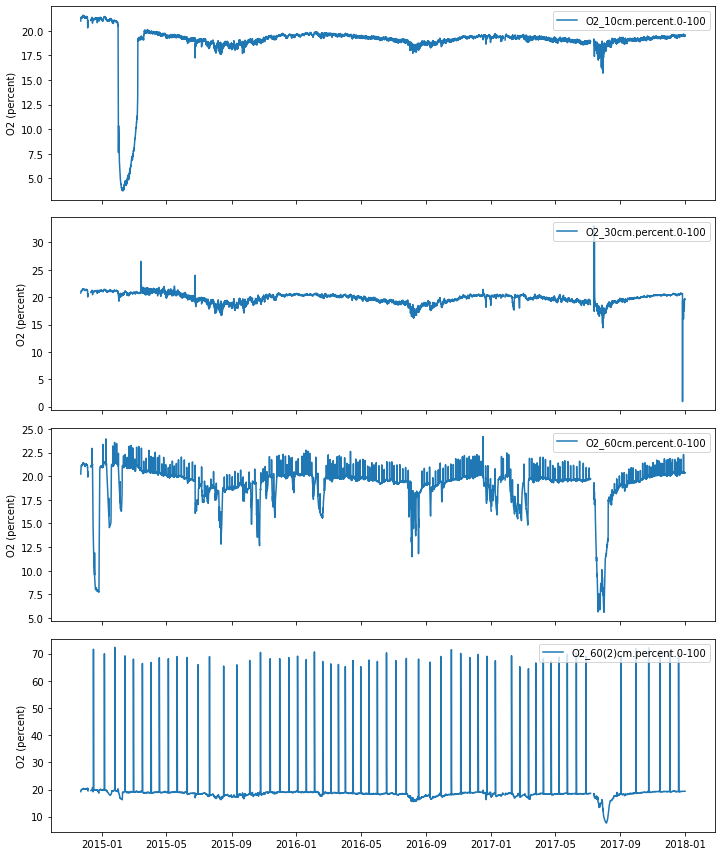

In [7]:
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

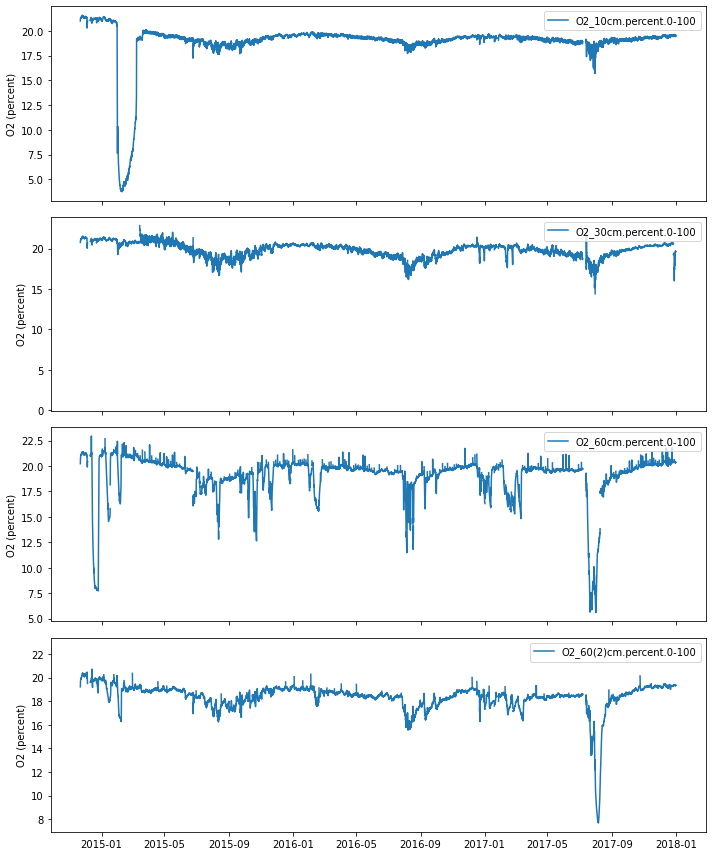

In [8]:
# Plot O2 data
# O2 mask and remove_spikes produce curves with less noise. But are we sure that O2 can't be higher than 23? Also, I'm not sure what the best window size is.
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=23, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']>=23, inplace=True)
df['O2_60cm.percent.0-100'].mask(df['O2_60cm.percent.0-100']>=23, inplace=True)
df['O2_60(2)cm.percent.0-100'].mask(df['O2_60(2)cm.percent.0-100']>=23, inplace=True)

remove_spikes(df, 'O2_30cm.percent.0-100', window=3, threshold=1.5)
remove_spikes(df, 'O2_60cm.percent.0-100', window=3, threshold=1.2)
remove_spikes(df, 'O2_60(2)cm.percent.0-100', window=2, threshold=.5)

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

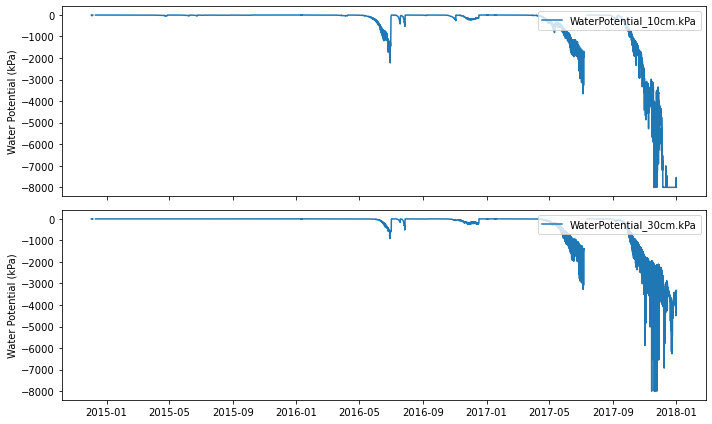

In [9]:
#Plot water potential
water_cols = [col for col in df.columns if 'Water' in col]
plot_cols(water_cols, ylabel='Water Potential (kPa)');

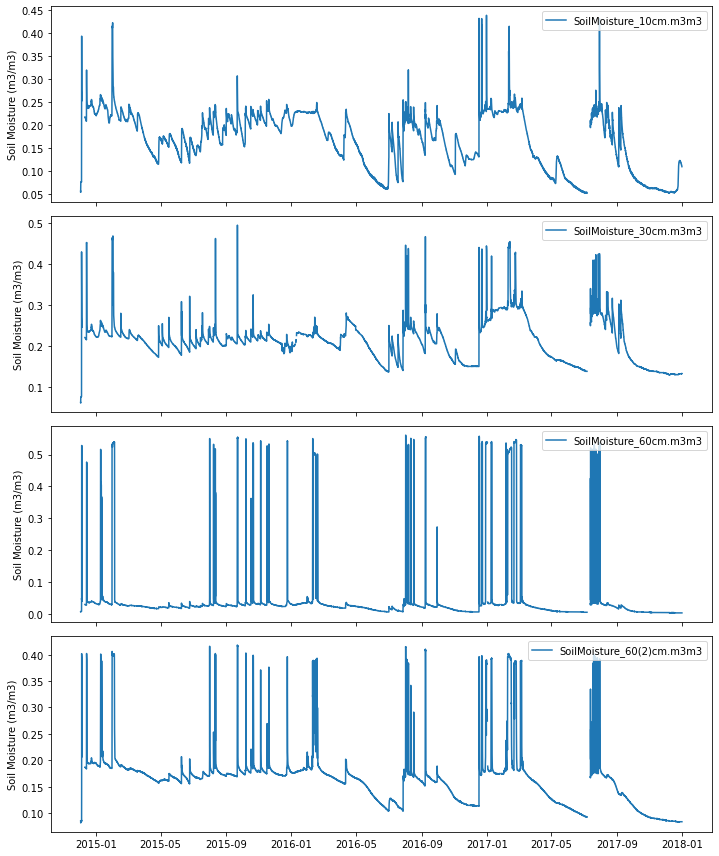

In [10]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

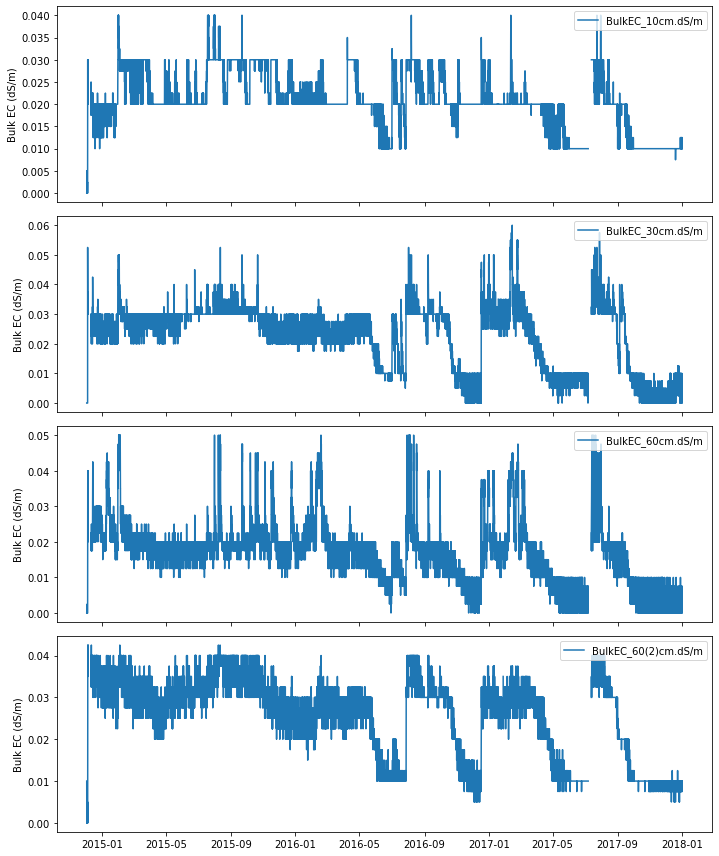

In [11]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

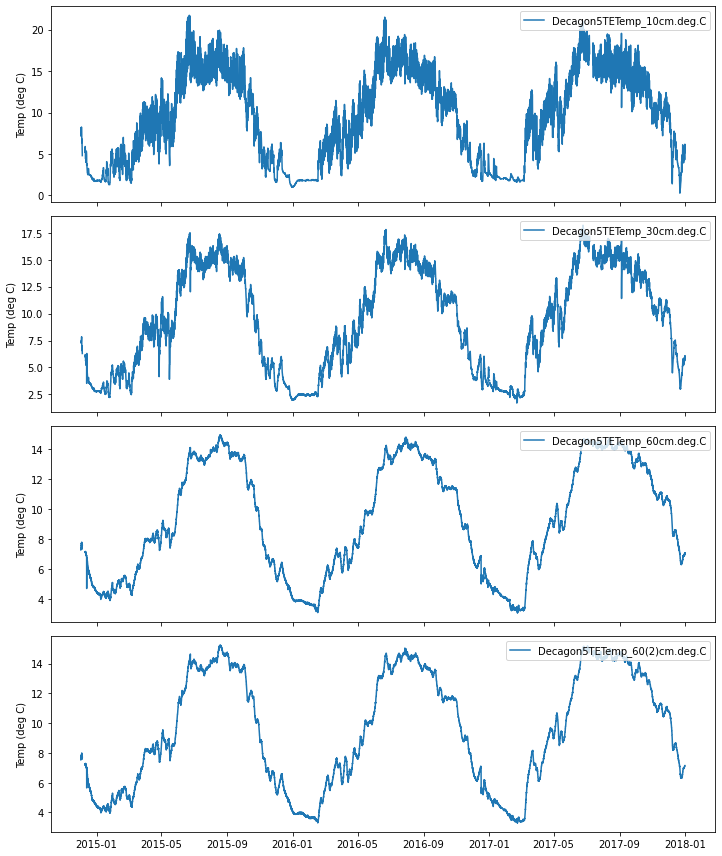

In [12]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [13]:
df.drop([col for col in df.columns if 'Decagon' in col], axis=1, inplace=True)
df.drop([col for col in df.columns if '60(2)' in col], axis=1, inplace=True)

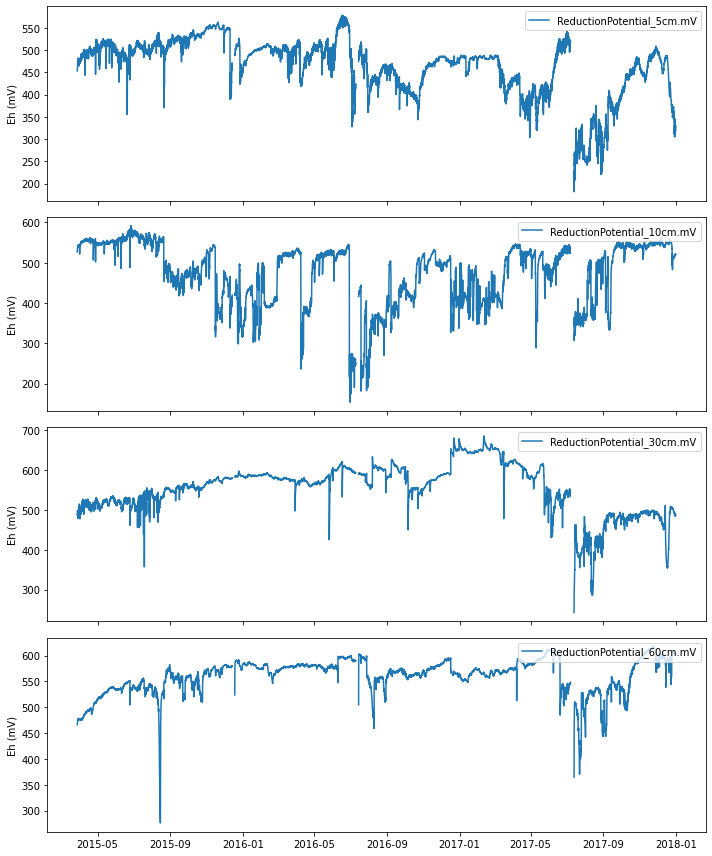

In [14]:
# Plot redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [15]:
df=df.drop(columns='ReductionPotential_5cm.mV')

In [18]:
SM_nan_index=df['SoilMoisture_30cm.m3m3'][df['SoilMoisture_30cm.m3m3'].notna()==False]
SM_not_nan_index=df['SoilMoisture_30cm.m3m3'][df['SoilMoisture_30cm.m3m3'].notna()==True]

print (len(SM_nan_index))
print (len(SM_not_nan_index))
print(len(SM_nan_index)/(len(SM_nan_index)+len(SM_not_nan_index)))

mask = df['SoilMoisture_30cm.m3m3'].isna()
d_SM = df.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first', 'size'])
d_SM.rename(columns=dict(size='num of contig null', first='Start_Date')).reset_index(drop=True)


CO2_nan_index=df['CO2_10cm.ppm'][df['CO2_10cm.ppm'].notna()==False]
CO2_not_nan_index=df['CO2_10cm.ppm'][df['CO2_10cm.ppm'].notna()==True]

print (len(CO2_nan_index))
print (len(CO2_not_nan_index))
print(len(CO2_nan_index)/(len(CO2_nan_index)+len(CO2_not_nan_index)))

mask = df['CO2_10cm.ppm'].isna()
d_CO2 = df.index.to_series()[mask].groupby((~mask).cumsum()[mask]).agg(['first', 'size'])
d_CO2.rename(columns=dict(size='num of contig null', first='Start_Date')).reset_index(drop=True)

print (np.mean(d_CO2['size']))
print (np.std(d_CO2['size']))

780
26496
0.028596568411790584
518
26758
0.018991054406804517
37.0
42.98504723405903


In [16]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/BGZOB1_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [17]:
output

,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,CO2_10cm.ppm,CO2_30cm.ppm,CO2_60cm.ppm,WaterPotential_10cm.kPa,...,SoilMoisture_10cm.m3m3,SoilMoisture_30cm.m3m3,SoilMoisture_60cm.m3m3,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,ReductionPotential_10cm.mV,ReductionPotential_30cm.mV,ReductionPotential_60cm.mV,PRISM_precip.mm
2014-11-21 12:00:00,4.691333,5.132667,6.428333,20.99300,20.748667,20.233667,1870.97100,3808.55200,1577.290333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 13:00:00,4.943750,5.359500,6.675250,21.20625,20.915250,20.456750,2031.52775,4227.88325,1820.810000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 14:00:00,5.082000,5.386500,6.658500,21.19550,20.895500,20.514750,2009.46875,4406.97625,1988.817750,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 15:00:00,5.268000,5.422500,6.650250,21.18425,20.900500,20.575500,1963.30525,4489.11725,2048.501750,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 16:00:00,5.121000,5.441500,6.622750,21.20450,20.903000,20.631000,1917.78125,4493.27125,2117.925500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,6.174750,6.192250,6.793250,19.51850,19.631750,20.341500,1303.72875,2117.93800,1750.028250,-7941.00,...,0.10950,0.13375,0.003,0.0100,0.0075,0.0025,519.500,487.500,603.575,NaN
2017-12-31 20:00:00,6.035750,6.215500,6.811750,19.52925,19.628250,20.349500,1295.31275,2118.23450,1753.951000,-7931.25,...,0.10900,0.13400,0.003,0.0100,0.0075,0.0050,519.925,487.250,603.575,NaN
2017-12-31 21:00:00,5.955500,6.232250,6.813250,19.55050,19.630000,20.357500,1284.22825,2111.23275,1761.204250,-7991.25,...,0.10900,0.13400,0.003,0.0100,0.0075,0.0025,520.775,486.675,603.475,NaN
2017-12-31 22:00:00,5.858500,6.235000,6.816750,19.55550,19.630000,20.356000,1285.30025,2110.38875,1760.519750,-7999.00,...,0.10900,0.13375,0.003,0.0125,0.0025,0.0025,520.925,486.825,603.550,NaN
